# Sandbox

A space for random tinkering. At the moment a workspace for WMT content for the SciDAC poster.

In [1]:
import numpy as np
import xarray as xr
import sys
import yaml
from importlib import reload
from dateutil.parser import parse
from matplotlib import pyplot as plt, patches, ticker
from fastjmd95 import rho
from cartopy import crs, feature

# Import modules from path
sys.path.append('../modules/')
import visualizationtools as viz
import build_mpas_2Dtimeavgs as wmt

# Set plot font sizes
plt.rcParams.update({'font.size': 10, 'axes.titlesize': 'medium'})

***

# Poster text

**Water mass analysis**

A mode water formation diagnostic has been developed for MPAS-Ocean based on the Walin (1982) water mass transformation framework.

$$\underbrace{F(\rho) = \frac{\partial}{\partial\rho}\iint_{\rho_0}^{\rho}\Phi_{\rho}ds}_{\text{Transformation}} \hspace{1cm} \underbrace{M(\rho) = - \frac{\partial F}{\partial\rho}}_{\text{Formation}}$$

   - $\rho$ surface density
   - $\Phi_{\rho}$ surface density flux
   - $\iint_{\rho_0}^{\rho} ds$ area integral over isopycnal surface outcrop

**CORE forced simulations**

This diagnostic is applied to 20th century CORE-forced simulations in order to evaluate the importance of model resolution in determining surface mode water formation.

   - Low resolution (LR, EC30to60E2r2): eddy-parameterized (GM/Redi), unstable AMOC
   - High resolution (HR, oRRS18to6v3): eddy-resolving, stable AMOC

**Preliminary diagnostics**

   - Subpolar Mode Water (SPMW) formation defined as $M$ integrated over $27.3 < \sigma < 28$ ($\sigma = \rho - 1000$)
   - SPMW formation is stronger at HR, especially in the western subpolar gyre (SPG) and Labrador Sea.
   - The SPG is warmer, saltier and denser at HR which allows more surface heat loss at SPMW density classes.
   - SPMW formation intensifies over time at HR but weakens over time at LR.

(Show figures here...)

**Next steps**

Identify differences in inter-gyre connectivity and vertical mixing between the two simulations that may explain the SPG temperature and salinity differences driving SPMW formation.

***

## Spatial maps for poster

In [2]:
# Path, meshes and timeranges
resultspath = '/pscratch/sd/b/bmoorema/results/aggregated/lonlat/'
meshes = ['EC30to60E2r2', 'oRRS18to6v3']
timeranges = [
    ('1947 Jan 1', '1956 Dec 31'),
    ('1997 Jan 1', '2006 Dec 31'),
]
timeranges = [[parse(t) for t in trange] for trange in timeranges]

# Loop though meshes and timeranges
ds = {mesh: {} for mesh in meshes}
for mesh in meshes:
    for timerange in timeranges:
        
        # Construct strings and load 2D fields via xarray
        tstr = '_'.join(date.strftime('%Y%m%d') for date in timerange)
        fn = resultspath + '20210421_sim7_CORE_' + mesh + '.mpas2Dtimeavg_wmtf_' + tstr + '.nc'
        tstr = '-'.join(str(date.year) for date in timerange)
        ds[mesh][tstr] = xr.open_dataset(fn)

In [194]:
def plot_2Dpanel(
    ax, ds, varname=None, xlim=[-100, 20], ylim=[0, 80],
    clim=[None, None], cmap=None, plot_sigma=False,
):
    """Plot 2D variable given by `varname` and overlay sigma
    contours if requested. If no varname provided, `ds` is
    treated as an `xr.DataArray` and thus the plotting variable.
    """
    
    # Sigma contour styling
    sigma_levels = {
        'levels'    : np.arange(25, 28, 0.5),
        'linestyles': ['-', '--', '-', '--', '-', '--'],
        'colors'    : ['k', 'k', 'gray', 'gray', 'lightgray', 'lightgray'],
    }
    
    proj_ref = crs.PlateCarree()
    ax.set_extent([-80, -10, 10, 80])
    ax.coastlines(zorder=1)
    ax.add_feature(feature.LAND, color='lightgray', zorder=0)
    
    # Plot variable
    variable = ds[varname] if varname is not None else ds
    variable = variable.where(abs(variable)>1e-2)
    levels = [level + np.random.normal(scale=1e-10) for level in np.arange(*clim, 10)]
    c = ax.contourf(ds.lon, ds.lat, variable, levels=levels, cmap=cmap, extend='both', transform=proj_ref, zorder=-1)
    for contour in c.collections:
        contour.set_edgecolor('face')

    # Plot sigma contours and add dummy plots for legend
    if plot_sigma:
        ax.contour(ds.lon, ds.lat, ds.sigmaTheta, **sigma_levels, transform=proj_ref, zorder=-1)
        for level, ls, color in zip(*list(sigma_levels.values())):
            ax.plot(0, 0, ls, color=color, label=level)

    return c, variable

Text(0.01, 0.74, '1997-2006\n(DJF)')

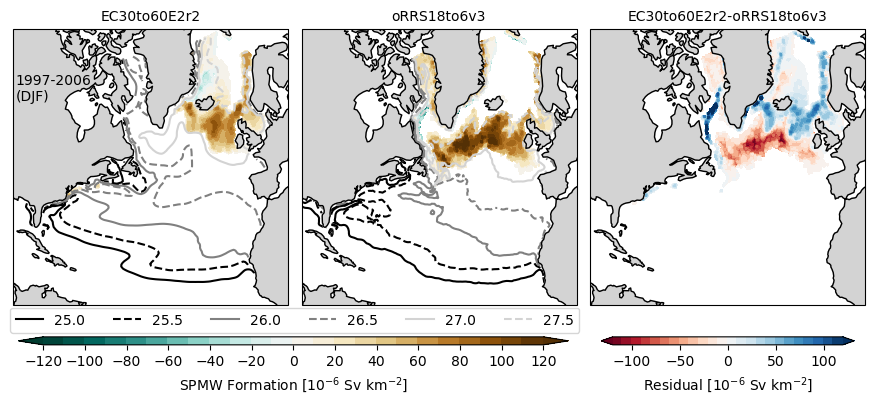

In [199]:
units = '[10$^{-6}$ Sv km$^{-2}$]'
kwargs = {
    'figsize': (11, 4),
    'subplot_kw': {'projection': crs.LambertConformal(-40, 0)},
    'gridspec_kw': {'hspace': 0.05, 'wspace': 0.05},
}
fig, axs = plt.subplots(1, 3, **kwargs)
for ax, title in zip(axs, meshes + [f'{meshes[0]}-{meshes[1]}']):
    ax.set_title(title)

res = []
for ax, mesh in zip(axs, meshes):
    ds_slc = ds[mesh]['1997-2006'].sel(months=[12, 1, 2]).mean(dim='months')
    ds_slc = ds_slc.sel(sigmaBins=slice(27.3, 28)).sum(dim='sigmaBins', skipna=False)
    c1, variable = plot_2Dpanel(ax, ds_slc, 'totalForm', clim=[-120, 121], cmap='BrBG_r', plot_sigma=True)
    res.append(variable.where(~np.isnan(variable), 0))

res = np.subtract(*res)
c2, _ = plot_2Dpanel(axs[2], res, clim=[-120, 121], cmap='RdBu')

cax1 = fig.add_axes([0.13, 0.05, 0.5, 0.02])
cax2 = fig.add_axes([0.66, 0.05, 0.23, 0.02])
cbar1 = fig.colorbar(c1, cax=cax1, label='SPMW Formation ' + units, orientation='horizontal', ticks=range(-120, 121, 20))
cbar2 = fig.colorbar(c2, cax=cax2, label='Residual ' + units, orientation='horizontal', ticks=range(-100, 101, 50))
for cbar in [cbar1, cbar2]:
    cbar.solids.set_edgecolor('face')

# Add sigma contour legend and frame label
axs[0].legend(ncols=7, loc=(-0.01, -0.1))
axs[0].text(0.01, 0.74, '1997-2006\n(DJF)', transform=axs[0].transAxes)

#fig.savefig('/pscratch/sd/b/bmoorema/results/figures/mpaso_LRHR_19470101_20061201_WMT-lonlatspace-DJF.pdf', bbox_inches='tight')

***

## TS space plots for poster

In [3]:
with open('../yaml/variable_definitions.yaml', 'r') as f:
    vardefs = yaml.safe_load(f)

# Path, meshes and timeranges
resultspath = '/pscratch/sd/b/bmoorema/results/aggregated/raw/'
meshes = ['EC30to60E2r2', 'oRRS18to6v3']
timeranges = [
    ('1947 Jan 1', '1956 Dec 31'),
    ('1997 Jan 1', '2006 Dec 31'),
]
timeranges = [[parse(t) for t in trange] for trange in timeranges]
tstrs = ['-'.join(str(date.year) for date in trange) for trange in timeranges]

# Loop though meshes and timeranges
ds = {}
for mesh in meshes:
        
    # Construct strings and load 2D fields via xarray
    fn = resultspath + '20210421_sim7_CORE_' + mesh + '.mpas2Daggregated_19470101_20061201.nc'
    ds[mesh] = xr.open_dataset(fn)
    tindex = ds[mesh].time.dt.month.isin([12, 1, 2])
    ds[mesh] = ds[mesh].sel(time=tindex)

In [4]:
varnames = ['salinity', 'temperature', 'dThreshMLD']
variables = {mesh: {tstr: {name: {} for name in varnames} for tstr in tstrs} for mesh in meshes}

for mesh in meshes:
    for timerange, tstr in zip(timeranges, tstrs):
        
        # Slice dataset
        ds_slc = ds[mesh].sel(time=slice(*timerange))
        lindex = ds_slc.lat.values > 50
        nmonths = len(ds_slc.time)
        
        # Conventional variables
        for name in varnames[:3]:
            values = ds_slc[name].values[:, lindex].flatten()
            variables[mesh][tstr][name] = {
                'mean': values.mean(),
                'IQR' : [np.percentile(values, p) for p in (40, 60)],
            }
        
        # Formation
        F = sum([ds_slc[ctgy + 'Factor'] * sum([ds_slc[name] for name in vardefs[ctgy]]) for ctgy in ('heat', 'salt')])
        F = (F * ds_slc.area).values[:, lindex].flatten()
        sigma = ds_slc.sigmaTheta.values[:, lindex].flatten()
        
        transformation = []
        for sigmabin in np.arange(27.3, 28.11, 0.1):
            
            mask = wmt.mask_interval(sigma, sigmabin, 0.1)
            
            transformation.append(F[mask].sum() / 0.1 / nmonths * 1e-6)
        
        variables[mesh][tstr]['totalForm'] = -sum(np.diff(transformation))

In [8]:
def get_plotvars(variables, name, ctgy=None):
    
    meshes = list(variables)
    tstrs = list(variables[meshes[0]])
    
    if ctgy is None:
        values = np.array([variables[mesh][tstr][name] for mesh in variables for tstr in tstrs])
    else:
        values = np.array([variables[mesh][tstr][name][ctgy] for mesh in variables for tstr in tstrs])
    
    lims = [150, 250] if name == 'dThreshMLD' else [0, 0]
        
    values = np.append(values, lims)
    
    labels = [mesh + '\n' + tstr for mesh in variables for tstr in tstrs]
    
    return values, labels

In [9]:
S, _ = get_plotvars(variables, 'salinity', ctgy='mean')
T, _ = get_plotvars(variables, 'temperature', ctgy='mean')
MLD, _ = get_plotvars(variables, 'dThreshMLD', ctgy='mean')
F, labels = get_plotvars(variables, 'totalForm')
MLD = (MLD - 100)**2 / 20

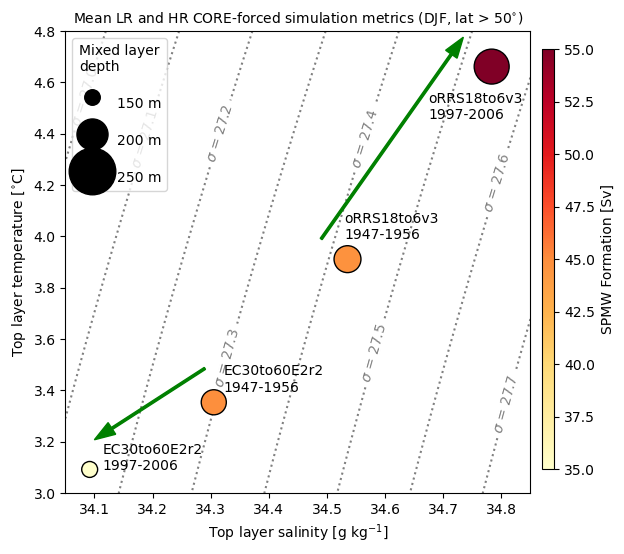

In [73]:
fig, ax = plt.subplots(figsize=(6, 6))
xlim, ylim = [34.05, 34.85], [3, 4.8]
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Top layer salinity [g kg$^{-1}$]')
ax.set_ylabel('Top layer temperature [$^{\circ}$C]')
ax.set_title('Mean LR and HR CORE-forced simulation metrics (DJF, lat > 50$^{\circ}$)')

sgrid, tgrid = np.linspace(*xlim, 100), np.linspace(*ylim, 100)
sigma = rho(*np.meshgrid(sgrid, tgrid), 0) - 1000

c = ax.contour(sgrid, tgrid, sigma, levels=np.arange(27, 27.8, 0.1), colors='gray', linestyles=':', zorder=-10)

sc = ax.scatter(S, T, s=MLD, c=F, vmin=35, vmax=55, cmap='YlOrRd', ec='k')
positions = [(0.34, 0.22), (0.08, 0.05), (0.6, 0.55), (0.78, 0.81)]
for label, pos in zip(labels, positions):
    ax.text(*pos, label, transform=ax.transAxes)

elements = sc.legend_elements(
    "sizes", fmt="\n{x:d} m",
    color='k', mec='k',
    num=ticker.FixedLocator(range(150, 251, 50)),
    func=lambda x: (x*20)**(1/2)+100,
)
ax.legend(*elements, title='Mixed layer\ndepth')

cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
fig.colorbar(sc, cax=cax, label='SPMW Formation [Sv]')

ax.clabel(c, fmt='$\sigma$ = %.1f')

ax.arrow(0.55, 0.55, 0.28, 0.4, transform=ax.transAxes, head_width=0.03, width=0.005, color='g')
ax.arrow(0.3, 0.27, -0.2, -0.13, transform=ax.transAxes, head_width=0.03, width=0.005, color='g')

#fig.savefig('/pscratch/sd/b/bmoorema/results/figures/mpaso_LRHR_19470101_20061201_WMT-TSspace-DJF.pdf', bbox_inches='tight')